# Wine quality classification

### Getting the source file from: 
https://www.kaggle.com/datasets/sahideseker/wine-quality-classification/data

In [9]:
import os
from pathlib import Path
container_check = os.getenv("iscontainer")
if container_check=="y":
    config_dir = Path("/home/vscode/.config/kaggle")
    config_dir.mkdir(parents=True, exist_ok=True)
    
    with open(config_dir / "kaggle.json", "w") as dst:
        with open("./kaggle.json", "r") as src:
            dst.write(src.read())

In [10]:
import os
import zipfile
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

#dataset = "wine-quality"  # original competition dataset
dataset_test = "sahideseker/wine-quality-classification"  # test set augmented with target labels
download_folder = Path("data/wine-quality")
download_folder.mkdir(parents=True, exist_ok=True)
inputFilePath = download_folder / "wine_quality_classification.csv"

#api.competition_download_files(dataset, path=str(download_folder))
api.dataset_download_files(dataset_test, path=str(download_folder), unzip=True)
print("Download complete.")
print(f"Path to file: {inputFilePath}")

Dataset URL: https://www.kaggle.com/datasets/sahideseker/wine-quality-classification
Download complete.
Path to file: data\wine-quality\wine_quality_classification.csv


### Data exploration

In [12]:
import pandas as pd
import numpy as np

# Load the dataset
ds = pd.read_csv(inputFilePath)
print(ds.head())

   fixed_acidity  residual_sugar  alcohol  density quality_label
0            9.3             6.4     13.6   1.0005          high
1           11.2             2.0     14.0   0.9912        medium
2           11.6             0.9      8.2   0.9935           low
3           12.9             6.6     12.7   1.0002           low
4           13.9            13.8     10.4   0.9942        medium


In [15]:
#Check for missing values
print("Null values in each column:")
print(ds.isnull().sum())
#Check for duplicates
print("Duplicate rows in the dataset:")
print(ds.duplicated().sum())
#Check for class imbalance
print("Class imbalance in the target variable:")
print(ds['quality_label'].value_counts())
#Check for outliers
print("Outliers in the dataset:")
print(ds.describe())
#Check for data types
print("Data types of each column:")
print(ds.dtypes)

Null values in each column:
fixed_acidity     0
residual_sugar    0
alcohol           0
density           0
quality_label     0
dtype: int64
Duplicate rows in the dataset:
0
Class imbalance in the target variable:
quality_label
medium    355
high      343
low       302
Name: count, dtype: int64
Outliers in the dataset:
       fixed_acidity  residual_sugar      alcohol      density
count    1000.000000      1000.00000  1000.000000  1000.000000
mean       10.174300         7.69200    11.039900     0.997505
std         3.452693         4.20892     1.760283     0.004300
min         4.000000         0.50000     8.000000     0.990000
25%         7.100000         4.10000     9.500000     0.993900
50%        10.400000         7.55000    11.000000     0.997400
75%        13.125000        11.50000    12.600000     1.001200
max        16.000000        15.00000    14.000000     1.005000
Data types of each column:
fixed_acidity     float64
residual_sugar    float64
alcohol           float64
density

#### Divide the data

In [ ]:
#train test split
from sklearn.model_selection import train_test_split

X = ds.drop(columns=['quality_label'])
y = ds['quality_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train test split complete.")


Train test split complete.


In [30]:
#Check size of the split
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (800, 4)
X_test shape: (200, 4)


In [21]:
#Model training
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Define the model
model = RandomForestClassifier(random_state=42)
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [22]:
# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=2)
# Fit the model
grid_search.fit(X_train, y_train)
# Get the best model
best_model = grid_search.best_estimator_
print("Model training complete.")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Model training complete.


Model evaluation:
              precision    recall  f1-score   support

        high       0.33      0.34      0.34        71
         low       0.30      0.26      0.28        62
      medium       0.36      0.40      0.38        67

    accuracy                           0.34       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.33      0.34      0.33       200

Confusion matrix:
[[24 22 25]
 [24 16 22]
 [24 16 27]]


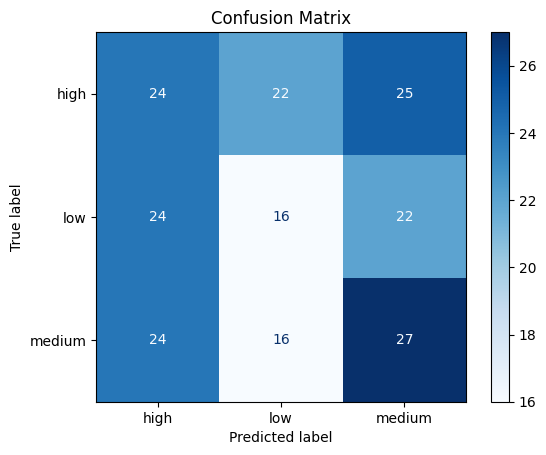

In [29]:
# Make predictions
y_pred = best_model.predict(X_test)
# Evaluate the model
print("Model evaluation:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# Present confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [35]:
# Change model to Catboost
from catboost import CatBoostClassifier
# Define the model
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
# Define the hyperparameters to tune
param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}
# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=2)
# Fit the model
grid_search.fit(X_train, y_train)
# Get the best model
best_model = grid_search.best_estimator_
print("Model training complete.")


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Model training complete.


Model evaluation:
              precision    recall  f1-score   support

        high       0.35      0.35      0.35        71
         low       0.21      0.05      0.08        62
      medium       0.37      0.64      0.47        67

    accuracy                           0.35       200
   macro avg       0.31      0.35      0.30       200
weighted avg       0.32      0.35      0.31       200

Confusion matrix:
[[25  9 37]
 [24  3 35]
 [22  2 43]]


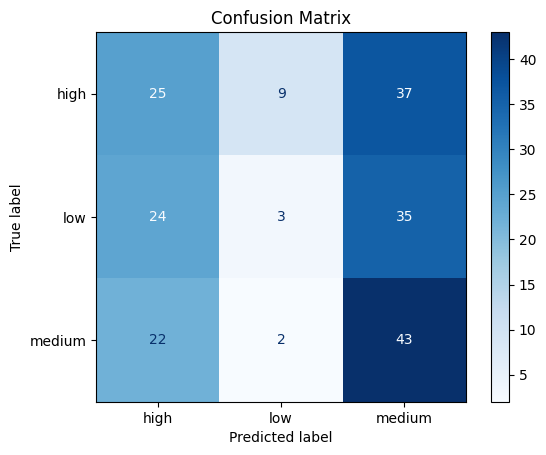

In [36]:
# Predict
y_pred = best_model.predict(X_test)
# Evaluate the model
print("Model evaluation:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
# Present confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()